---

<div align="center" style="font-size:24pt">BE 5370 (2024) Registration Assignment Phase I</div>

---
# Introduction

This Phase of the assignment focuses on rigid/affine registration. You will write code to apply affine transformations to images and then use the PyTorch optimization and auto-differentiation tools to implement affine and rigid registration between pairs of images.

Your grade will be graded according to the following criteria:

* Successful completion of all components of the notebook: **75 pts**.
* Overall quality of the writing, plots, figures, and code: **25 pts**.

# Preliminaries

Load the packages required for this assignment, including `upenn_be5370_utils`. Be sure to update your copy of this package using `pip install --upgrade`

In [1]:
# Import the libraries we need
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pandas as pd
import matplotlib.pyplot as plt
import time

# Import our libraries
from upenn_be5370_utils.sitkview import view_sitk
from upenn_be5370_utils.transforms import *

In the cell below, point the `root` directory to the location of the data folder for this homework. Also set the variables `id_fix` and `id_mov` to another pair of identifiers.

In [2]:
import random

In [7]:
# Root directory for the dataset
root = './data'

# Fixed and moving images (change these to an arbitrary pair of subject ids)
id_fix = random.randint(1001, 1019)
id_mov = random.randint(1001, 1019)
# id_fix, id_mov = 1009, 1015
print(id_fix,id_mov)

1009 1011


# Step 1. Working with 3D Images in PyTorch (10 pts)

In this step, you will learn how to load 3D medical images into Pytorch tensors and how to apply simple image processing using the Pytorch tensor library. This is really to get you comfortable using PyTorch for 3D data.

Let's start by loading one of the images in the atlas dataset, and its segmentation. We can then take a look at the new `view_sitk` function.

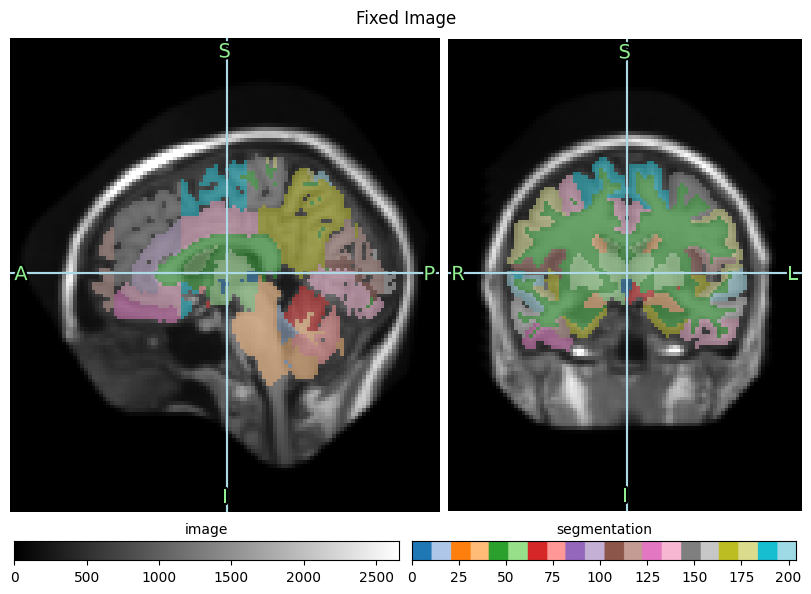

In [8]:
# Read the fixed image for image processing
img = sitk.ReadImage(f'{root}/images/atlas_2mm_{id_fix}_3.nii.gz')

# Also read the corresponding segmentation image
seg = sitk.ReadImage(f'{root}/images/atlasseg_2mm_{id_fix}_3.nii.gz')

# Show the image and the segmentation
view_sitk(img, seg, cmap=['gray','tab20'], name=['image', 'segmentation'], width=8, title='Fixed Image');

## Task 1A. Mapping 3D Datasets between SimpleITK and PyTorch

Write the code for functions below to map between SimpleITK 3D images and Torch tensors:

  -  Most PyTorch routines that work with 3D arrays will expect their inputs to have **five** dimensions, denoted in the PyTorch documentation as `[B,C,D,H,W]`, where `B` is the mini-batch size, `C` is the number of channels/components, and `DxHxW` are the dimensions of the 3D array (depth, height, width). Throughout this assignment, the mini-batch size will be 1. The number of channels will vary. 
  
  - However, when describing spatial transformations, PyTorch uses a different format, described in the documentation of `torch.nn.functional.grid_sample`. A 3D spatial transformation, or warp, is encoded as a tensor of shape `[B,D,H,W,3]`, where the last dimension is used to store 3-dimensional displacement vectors in each voxel of the image. 
  
  - Your functions should be able to map between PyTorch and SimpleITK for three types of images:

    - 3D scalar images should map to [1,1,D,H,W] tensors
  
    - 3D spatial transformations should map to [B,D,H,W,3] tensors (`is_warp=True`)
  
    - Other 3D multi-component images should map to [1,C,D,H,W] tensors (`is_warp=False`)

  - When writing these functions, here are some hints:
  
    - You can first get these functions working for scalar images, then come back to implement multi-component images and spatial transformations when you need this functionality later in the assignment. 

    - Note the argument `**kwargs` in the methods' signature. This is a standard Python way to allow a function to [take a variable number of arguments](https://book.pythontips.com/en/latest/args_and_kwargs.html). We want the user of `my_sitk_to_torch` to be able to pass arguments to the PyTorch tensor creation routines (e.g., `torch.tensor`), including data type (`dtype`), device (`device`) and whether to compute/retain the gradient of the tensor during back-propagation (`needs_grad`). To pass these arguments to PyTorch when creating a tensor, write `torch.tensor(..., **kwargs)`
        
    - Use `sitk.GetArrayFromImage` and `sitk.GetImageFromArray` functions to get arrays in and out of the ITK image.

    - Use `sitk.Image.GetNumberOfComponentsPerPixel` to tell apart scalar and multi-component images.apart 
    
    - Use `sitk.Image.CopyInformation` to update the header of the output image in `my_torch_to_sitk` based on the header of the reference image.
    
    - To add singleton dimensions to a tensor, you can use the tensor method `unsqueeze` or you can use indexing like `T[:,None,:]`.
    
    - To reorder the dimensions in a tensor, use `tensor.permute()`

    - To get a NumPy array with the contents of a PyTorch tensor `T`, use `T.detach().cpu().numpy()`

        


In [48]:
# Code to go between pytorch and sitk
def my_sitk_to_torch(img, is_warp=False, **kwargs):
    """
    Convert 3D SimpleITK image to PyTorch 5D tensor. Supports scalar images
    and vector (multi-component) images.

    Args:
        img: 
            SimpleITK image, 3D scalar or vector image
        is_warp:
            Boolean, indicates whether multi-component images should be treated as
            spatial transformations [1,D,H,W,3] or multi-channel images [1,C,D,H,W]
        dtype, device:
            These parameters will be passed on to torch.tensor()
    Output:
        A torch tensor holding the voxel data
    """
    # --- WRITE YOUR CODE HERE (~11 lines plus comments) ---


def my_torch_to_sitk(T, ref, is_warp=False):
    """
    Convert a PyTorch 5D tensor to a 3D SimpleITK image. Supports scalar images
    and vector (multi-component) images.

    Args:
        T: 
            A 5-D tensor representing a scalar 3D image [1,1,D,H,W], a multi-channel 
            3D image [1,C,D,H,W], or or a 3D spatial transformation [1,D,H,W,3] 
        ref:
            Reference 3D image, a SimpleITK image from which the metadata including
            spacing, origin, and direction matrix will be assigned to the output image.
        is_warp:
            Boolean, indicates if the tensor represents a spatial transformation. If so,
            the tensor is expected to have shape [1,D,H,W,3].

    Output:
        A SimpleITK image.
    """
    # --- WRITE YOUR CODE HERE (~13 lines plus comments) ---

The code below can be used to test the very basic functionality of your function:

In [49]:
# Compute the negative image
T_img = my_sitk_to_torch(img, dtype=torch.float32)
T_neg = torch.max(T_img) - T_img
img_neg = my_torch_to_sitk(T_neg, img)

# Remove all odd labels in the segmentation
T_seg = my_sitk_to_torch(seg, dtype=torch.int16)
T_seg_even = torch.where(T_seg % 2 == 1, T_seg, torch.zeros_like(T_seg))
seg_even = my_torch_to_sitk(T_seg_even, img)

# Show the result
view_sitk(img, img_neg, seg_even, layout='tto', cmap=['gray','gray','tab20'], 
          name=['image', 'negative', 'segmentation'], width=10);

## Task 1B. Use PyTorch to Report Statistics

Write code to report the volume and mean MRI intensity for labels 31 (right amygdala), 32 (left amygdala), 47 (right hippocampus), 48 (left hippocampus), 51 (right lateral ventricle) and 52 (left lateral ventricle).

  - Your code should only use PyTorch routines, and should not have any `for/while` loops over the voxels. Make sure to report volume in `mm^3`!

  - You can report your data in a table on a plot. A horizontal bar plot `barh` in `matplotlib` is a good choice. 

  - Compare your results with `Segmentation->Volume and Statistics` in ITK-SNAP. You should see the same values using PyTorch and ITK-SNAP.

<p style="text-align: center;"><img width="40%" src="https://raw.githubusercontent.com/pyushkevich/upenn_be5370_utils/main/doc/figs/rp1/snap_volstat.png"></img><br>Volumes and Intensity Statistics window in ITK-SNAP</p>


In [50]:
# Define the labels we want to report
labels = {
    31: 'Right Amygdala',
    32: 'Left Amygdala',
    47: 'Right Hippocampus',
    48: 'Left Hippocampus',
    51: 'Right Lateral Ventricle',
    52: 'Left Lateral Ventricle',
}

# --- WRITE YOUR CODE HERE (~13 lines plus comments) ---

## Task 1C. Implement the Sobel Filter in PyTorch.

The Sobel filter is one of the simplest filters for edge detection. We don't really care about edge detection per se in this assignment, but it is a good way to play with some PyTorch tensor features. In two dimensions, the Sobel operators in the $x$ and $y$ direction have the form of $3 \times 3$ matrices below:

$$
S_x = 
\begin{bmatrix}
+1 & 0 & -1 \\
+2 & 0 & -2 \\
+1 & 0 & -1 \\
\end{bmatrix} 
\qquad
S_y = 
\begin{bmatrix}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1 \\
\end{bmatrix} 
$$

Convolution between an image and the Sobel operator $S_x$ gives an approximation of the partial derivative of the image intensity in the $x$ direction, likewise for $y$. So convolving the image with both $S_x$ and $S_y$ and storing the results in different channels gives us an approximation of the image gradient. Same is true for 3D, and this [Wikipedia article on the Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) gives a good explanation of the 2D Sobel operator and its extension to 3D.

Please write code to compute the approximation of the gradient of the image `img` using the Sobel operators in $x$, $y$, $z$. 

  - Your code should use the routine `torch.nn.functional.conv3d` to compute the convolution between the MRI scan and the Sobel operators in $x$, $y$, and $z$ directions. Read the documentation of this function first. The function takes a lot of parameters, but you only need to supply `input`, `weight`, and `padding='same'`. You should only need to call `conv3d` once to perform all three convolutions ($x$, $y$, and $z$).

  - To construct the Sobel operators, you should not need to write any loops or long expressions. Think how the Sobel operators can be represented as an outer product of 1D vectors, and use PyTorch tensor library to construct your operators. One function you might fund useful here is `torch.einsum`, and there are many other ways to construct the operator as well.

  - Convert the result of your convolution to a SimpleITK multi-component image using `my_torch_to_sitk`, and display it using `view_sitk`. 

<p style="text-align: center;"><img width="60%" src="https://raw.githubusercontent.com/pyushkevich/upenn_be5370_utils/main/doc/figs/rp1/snap_sobel.png"></img><br>Sobel filter computed in PyTorch for an MRI scan</p>


In [51]:
# --- WRITE YOUR CODE HERE (~9 lines plus comments) ---


**Congratulations!** You have successfully accomplished a couple image processing tasks in PyTorch. Now we are ready to start with actual image registration!

# Step 2. Perform Registration in ITK-SNAP (5 pts)

In this step, you will load a pair of images in ITK-SNAP and perform affine registration in an interactive environment. 

-   Download and install the latest stable **ITK-SNAP** release for your architecture from http://itksnap.org.
 
-   Open the image you chose to serve as the fixed image in ITK-SNAP. Also load the segmentation of the fixed image.

-   Open the image you chose to serve as the moving image as an additional image layer (`File->Add Another Image...`) in ITK-SNAP. Experiment with different ways to display the moving image relative to the fixed (as an overlay, side by side, flip between fixed and moving). You can hide the segmentation by setting its opacity to zero (press the `S` key; press it again to restore the previous opacity value).

-   Use the registration tool (`Tools->Registration`) to perform registration between images. Try manual and automatic modes.  Experiment with different registration settings (e.g., rigid vs. affine, different metrics, using the segmentation image as a mask). Confirm that registration improves alignment between images visually.

<p style="text-align: center;"><img width="70%" src="https://raw.githubusercontent.com/pyushkevich/upenn_be5370_utils/main/doc/figs/rp1/snap_registration.png"></img><br>Registration between two images in ITK-SNAP</p>

-   Save the registration result (orange arrow above) as a file `snap_affine_transform_fxFFFF_mvMMMM.mat` where `FFFF` is the 4-digit id of the fixed image and `MMMM` is the id of the moving image.

    - Note the naming convention here. Sometimes people will to call the transformations `affine_XXX_to_YYY`, but this can leave some ambiguity about which image is the fixed and which is the moving. By using `fx` and `mv` in the file name, we leave no ambiguity about which image is fixed and which is moving.

-   Reslice the moving image into the voxel grid of the fixed image (purple arrow above). 

    - Observe that the resulting image looks very similar to the transformed moving image, but has the same metadata (size, origin, spacing, direction matrix) as the fixed image. Use `Tools->Image Information...` to view metadata.

-   Save the resliced image as `snap_affine_reslice_fxFFFF_mvMMMM.nii.gz`

>**PROMPT:** In this Markdown cell, include screenshots demonstrating the images loaded and co-registered in ITK-SNAP. In a short paragraph describe what automatic registration settings provided the best registration and how well automatic registration did compared to manual registration.

# Step 3. Implement Affine Transformations and Reslicing in PyTorch (10 pts)

In this step, you will use PyTorch routines `torch.nn.functional.affine_grid` and `torch.nn.functional.grid_sample` to apply an affine transformation to the moving image and reslice it into the space of the fixed image. 


Start by carefully reading the documentation of these two commands. Pay special attention to the coordinate system that PyTorch uses for spatial transformations (i.e., the corners of the image have physical coordinates $[-1,-1,-1]$ and $[1,1,1]$). 

Using these functions, write the code for the function below.

In [52]:
# Function to apply the affine transform in voxel coordinates to a moving image represented
# as a PyTorch tensor
def my_transform_image_pytorch(T_ref, T_mov, A, b, 
                               mode='bilinear', padding_mode='zeros'):
    """
    Apply an affine transform to 3D moving image and reslice it into the space of the 
    fixed (reference) image.
    
    Args:
        T_ref: 
            Fixed (reference) image, a shape (1,Cf,Df,Hf,Wf) tensor
        T_mov: 
            Moving image, represented a shape (1,Cm,Dm,Hm,Wm) tensor
        A:
            Affine transformation matrix in PyTorch coordinate space, a shape (3,3) tensor
        b:
            Translation vector in PyTorch coordinate space, a shape (3) tensor
        mode: 
            Interpolation mode, see documentation for `grid_sample`
        padding_mode: 
            Padding mode, see documentation for `grid_sample`

    Output:
        Moving image transformed and resliced into reference image space, 
        a shape (1,Cm,Df,Hf,Wf) tensor
    """
    # --- WRITE YOUR CODE HERE (~3 lines plus comments) ---

The snippet below can be used to test your code. It reslices the moving image into the fixed image space using the matrix that you saved in ITK-SNAP. The function `map_affine_sitk_to_pytorch` takes care of the messy work of transforming the affine parameters to account for differences between the ITK and PyTorch physical coordinate systems.

In [53]:
# Load the fixed and moving images
img_fix = sitk.ReadImage(f'{root}/images/atlas_2mm_{id_fix}_3.nii.gz')
img_mov = sitk.ReadImage(f'{root}/images/atlas_2mm_{id_mov}_3.nii.gz')

# Map to tensors
T_fix, T_mov = (my_sitk_to_torch(x, dtype=torch.float32) for x in (img_fix, img_mov))

# Load the transform into an sitk object (replace the filename with yours)
tran_itk = load_itksnap_transform(f'data/snap_affine_transform_fx{id_fix}_mv{id_mov}.mat')
print(f'Transform parameters in SimpleITK: {tran_itk.GetMatrix()}, {tran_itk.GetTranslation()}')

# Convert to the format compatible with affine_grid
A, b = map_affine_sitk_to_pytorch(tran_itk, img_fix, img_mov)
T_A, T_b = (torch.tensor(x, dtype=torch.float32) for x in (A,b))
print(f'Transform parameters in PyTorch: {A.flatten()}, {b}')

# Apply transformation
T_resampled = my_transform_image_pytorch(T_fix, T_mov, T_A, T_b)
img_resampled = my_torch_to_sitk(T_resampled, img_fix)

# Visualize the result
view_sitk(img_fix, img_resampled, img_mov, 
          name=['Fixed Image','Resampled Moving Image','Original Moving Image'], 
          layout='ttt', width=12, cmap='gray', title='Fixed, Resampled and Original Moving Images');

# Step 4. Function to Parameterize Rotations (15 pts)

Write a function that generates a 3x3 rotation matrix given a three-parameter vector. You can use Euler angle representation, exponent map (Rodrigues formula), or quaternions. Either way, your function should return the identity matrix for input `[0,0,0]` and it should be continuous and differentiable with respect to the inputs almost everywhere (i.e., Gimbal lock is ok) 

Before you start this section, some general hints:

  - You need to know how to do linear algebra with PyTorch. Some basic functions you will need are matrix multiplication (`@` operator), matrix inversion (`torch.inverse`), determinant (`torch.det`) and trace (`torch.trace`)



> **PROMPT:** In this cell, write a short paragraph describing the approach you have chosen. Use formulas to describe the mathematical transformation from parameters to the rotation matrix implemented in your code.



In [54]:
def my_rotation_from_vector(x):
    """
    Generate a 3D rotation vector from three parameters.

    Args:
        x: 
            A torch tensor of shape (3). It contains the parameters of the rotation.
            [Write more detail about what the parameters mean geometrically]
    Output:
        A shape (3,3) tensor holding a rotation matrix corresponding to x
    """
    # --- WRITE YOUR CODE HERE (~7 lines plus comments) ---

The code below checks that your computation returns actual rotation matrices, i.e. ones that satisfy $R^t R = I$. You should see values very close to zero in the last column.

In [55]:
x_check = [ torch.zeros(3) ] + [ torch.rand(3) for i in range(5) ]
for x in x_check:
    R = my_rotation_from_vector(x)
    print(f'Parameters: {x.detach().cpu().numpy()}, |R^T @ R - I| = {torch.det(R.T @ R - torch.eye(3)).item()}')

The code below tests your rotation matrix computation. It plots the trace of the rotation matrix as a function of the three parameters around the point [0,0,0]. At the point [0,0,0], the trace should be equal to 3, and as the parameters are varied, it should reduce smoothly. 

In [56]:
x0 = torch.zeros(3)
t_range = np.linspace(-0.01, 0.01, 10000)
fx = np.array([ torch.trace(my_rotation_from_vector(torch.tensor([t, 0, 0], dtype=torch.float64))) for t in t_range ])
fy = np.array([ torch.trace(my_rotation_from_vector(torch.tensor([0, t, 0], dtype=torch.float64))) for t in t_range ])
fz = np.array([ torch.trace(my_rotation_from_vector(torch.tensor([0, 0, t], dtype=torch.float64))) for t in t_range ])
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].plot(t_range, fx); ax[0].set_title="X parameter"
ax[1].plot(t_range, fy); ax[1].set_title="Y parameter"
ax[2].plot(t_range, fz); ax[2].set_title="Z parameter"
fig.suptitle('Trace of the rotation matrix as a function of variying parameters around zero');
plt.tight_layout();

Next, use your function to generate a 15 degree ($\pi/12$) rotation of the moving image in the coronal plane (the plane shown on the right in `view_sitk`, with letters R,S,L,I). Apply this rotation to the moving image and visualize like we did above.

In [57]:
# --- WRITE YOUR CODE HERE (~7 lines plus comments) ---

However, what you will see is not a true rotation in the coronal plane, but an affine transformation that combines some rotation and some stretching. This is because the PyTorch coordinate space with image corners assigned coordinates [-1,-1,-1] and [1,1,1] has a different aspect ratio from the scanner physical space. The PyTorch coordinate space has voxel spacing $[2/D,2/H,2/W]$ where $D,H,W$ are the 3D image dimensions, whereas the actual medical images in this dataset have voxel spacing on $2.0$ in each dimension. So a rotation in PyTorch coordinate space does not correpond to rotation in physical space, and vice versa.

Your task is to write a function that will take a PyTorch tensor representing a rotation matrix $\mathbf{R}$, and transform to an affine matrix $\mathbf{A}$ so that the transformation $\mathbf{w}=\mathbf{A}\mathbf{x}$ in PyTorch coordinates corresponds to the transformation $\mathbf{z}=\mathbf{R}\mathbf{y}$ in physical coordinates, where $\mathbf{y}$ are the physical coordinates corresponding to the PyTorch coordinates $\mathbf{x}$ and $\mathbf{z}$ are the physical coordinates corresponding to the PyTorch coordinates $\mathbf{w}$, as illustrated in the diagram below.

<p style="text-align: center;"><img width="60%" src="https://raw.githubusercontent.com/pyushkevich/upenn_be5370_utils/main/doc/figs/rp1/torch_coord_rotation.png"></img><br>Mapping between PyTorch and physical coordinate spaces</p>

The transformation from PyTorch coordinates to physical coordinates can be computed using the function `get_pytorch_to_physical_coordinate_transform`, which is provided to you. For a given SimpleITK image, this function returns a 3x3 matrix $\mathbf{Q}$ and a 3x1 vector $\mathbf{p}$ that describe the affine transformation between the PyTorch and physical coordiantes (dashed lines in the Figure).

What you need to do is work out the equation for the matrix $\mathbf{A}$ (it will involve matrices $\mathbf{R}, \mathbf{Q_f}, \mathbf{Q_m}$ and their inverses), and fill out the code for the function below. 

> **PROMPT:** include in this cell your derivation for the matrix $\mathbf{A}$.

In [58]:
def map_rotation_to_pytorch_affine(R, img_fix, img_mov):
    """
    Find an affine transformation between a fixed image and a moving image 
    in PyTorch coordinates that corresponds to a rotation in physical space.

    Args:
        R:
            Rotation matrix, represented as a shape (3,3) PyTorch tensor
        img_fix:
            Fixed image for this registration, a SimpleITK image
        img_mov:
            Moving image for this registration, a SimpleITK image 
    Output:
        A an affine matrix, represented as a shape (3,3) PyTorch tensor
    """
    # --- WRITE YOUR CODE HERE (~5 lines plus comments) ---

Now use this function to write code to apply a 15 degree rotation to the moving image. This time, the rotation should actually look like rotation!

In [59]:
# --- WRITE YOUR CODE HERE (~9 lines plus comments) ---

# Step 5. Affine Registration in PyTorch (20 pts)

In this step, we you will implement affine registration. Note that this step does not use the rotation parametrization function from Step 4; that function will be used for rigid registration, which is one of the extension options in Step 6.

## Task 5A. Objective Function for Affine Registration

Write a function with the following signature. This function will use `my_transform_image_pytorch` to apply an affine transformation to the moving image, and will compute the sum of squared differences metric between the fixed image and the transformed moving image. This function will serve as the *objective function* for numerical optimization. By minimizing the intensity difference between the fixed image and resampled moving image as a function of the registration parameters $\mathbf{A}$ and $\mathbf{b}$, we will perform affine registration. 

* To avoid dealing with very large numbers, divide the SSD value by the total number of voxels in the fixed image. 

* To further avoid very large numbers and account for large shifts in image intensity, the function provides an option to z-transform the images (subtract the mean and divide by the standard deviation) before computing the metric


In [24]:

def my_affine_objective_ssd(T_fix, T_mov, T_A, T_b, z_transform=False):
    """
    Objective function for affine registration using the squared sum of differences (SSD) metric.
    
    Args:
        T_fix: Fixed (reference) image, a tensor of shape (1,C,Df,Hf,Wf)
        T_mov: Moving image, a tensor of shape (1,C,Dm,Hm,Wm)
        T_A: Affine matrix in PyTorch coordinate space, a tensor of shape (3,3)
        T_b: Translation vector in PyTorch coordinate space, a tensor of shape (3)
        z_transform: Whether to z-transform the image intensities before SSD computation.
    Output:
        Returns a singleton PyTorch tensor storing the value of the SSD metric.
    """
    # --- WRITE YOUR CODE HERE (~4 lines plus comments) ---


The next code box calls this function using the identity transform and using the transform you computed in ITK-SNAP

In [32]:
# Identity transform
T_A_id, T_b_id = (torch.tensor(x, dtype=T_fix.dtype) for x in (np.eye(3), np.zeros(3)))
ssd_id = my_affine_objective_ssd(T_fix, T_mov, T_A_id, T_b_id, z_transform=True)

# Transform from ITK-SNAP
tran_itk = load_itksnap_transform(f'data/snap_affine_transform_fx{id_fix}_mv{id_mov}.mat')
T_A_itk, T_b_itk = (torch.tensor(x, dtype=T_fix.dtype) for x in map_affine_sitk_to_pytorch(tran_itk, img_fix, img_mov))
ssd_itk = my_affine_objective_ssd(T_fix, T_mov, T_A_itk, T_b_itk, z_transform=True)

# Compare before and after
plt.bar(['No registration', 'ITK-SNAP'], [ssd_id.item(), ssd_itk.item()]);
plt.title('SSD metric (z-transformed) before and after ITK-SNAP registration');
plt.ylabel('SSD metric value');

Here comes the reason we have been suffering through PyTorch all along! PyTorch lets us compute the partial derivatives of the objective function with respect to $\mathbf{A}$ and $\mathbf{b}$ like this:

In [36]:
# Create versions of the tensors T_A and T_b that track their partial derivatives
T_A_id_grad, T_b_id_grad = (torch.tensor(x, dtype=T_fix.dtype, requires_grad=True) 
                            for x in (np.eye(3), np.zeros(3)))

# Compute the objective function (forward pass)
obj = my_affine_objective_ssd(T_fix, T_mov, T_A_id_grad, T_b_id_grad, z_transform=True)

# Compute the partial derivatives of the objective function with respect to
# elements of T_A_id_grad and T_b_id_grad automatically (backward pass)
obj.backward()

# Print the objective function value and partial derivatives
obj, T_A_id_grad.grad, T_b_id_grad.grad

Let's repeat this gradient computation for the affine transform we computed in ITK-SNAP

In [37]:
# Create versions of the tensors T_A and T_b that track their partial derivatives
T_A_itk_grad, T_b_itk_grad = (torch.tensor(x, dtype=T_fix.dtype, requires_grad=True) 
                              for x in map_affine_sitk_to_pytorch(tran_itk, img_fix, img_mov))

# Compute the objective function (forward pass)
obj = my_affine_objective_ssd(T_fix, T_mov, T_A_itk_grad, T_b_itk_grad, z_transform=True)

# Compute the partial derivatives of the objective function with respect to
# elements of T_A_id_grad and T_b_id_grad automatically (backward pass)
obj.backward()

# Print the objective function value and partial derivatives
obj, T_A_itk_grad.grad, T_b_itk_grad.grad

> **PROMPT:** In this cell, write a short paragraph discussing the gradient values in the two code cells above. Would you expect the values in the second cell to be larger or smaller than in the first cell? Would you expect the values in the second cell to be nearly zero? Why? Did the actual results agree with your expectations? If not, why do you think that might be?

## Task 5B. Optimization

To solve the registration problem, we need to minimize the objective function `my_affine_objective_ssd` with respect to the affine transform parameters. In the cell below, write the optimization code using two different approaches: stochastic gradient descent (`torch.optim.SGD`) and L-BFGS, a quazi-Newton method (`torch.optim.LBFGS`). Unfortunately, the PyTorch documentation for the optimization module is not always super clear, but [this gist](https://gist.github.com/tuelwer/0b52817e9b6251d940fd8e2921ec5e20) shows how to use both optimizers in a simple example.

Perform optimization using both optimizers and plot the history like in the linked example to compare convergence of the two optimizers. Your optimization should be initialized with the identity transform.

* For SGD, you will find that learning rate really matters. The value `1e-5` in the linked example gives slow convergence compared to LBFGS. Instead of SGD you can also use the Adam optimizer, it should perform more robustly.

* This is optional, but to implement a fair comparison, run both optimizers for the same amount of time (e.g., 30 seconds), and plot the objective function vs. time. This makes a difference because L-BFGS iterations are much slower due to multiple calls to the step function per iteration. Use `time.time()` to get the current system time.

In [79]:
# --- WRITE YOUR CODE HERE (~32 lines plus comments) ---

Lastly use the optimal parameters to reslice your moving image and plot the result of the registration using `view_sitk`.

In [81]:
# --- WRITE YOUR CODE HERE (~10 lines plus comments) ---

# Step 6. Extension Activities (15 pts)

These are slightly more open-ended extension activities. Please implement just one activity. Make sure to clearly explain your approach and discuss the results of your experiments. By "few image pairs", I mean 10-20 image pairs, selected at random; if computational time becomes an issue, you can use fewer pairs.

1. Implement rigid registration and compare affine and rigid registration in terms of the objective function convergence and registration result. Compare registration performance between $N$ iterations of affine registration, and $N/2$ iterations of rigid registration followed by $N/2$ iterations of affine (initialized with the best parameters from rigid registration). Try for a few pairs of images. Do you ever encounter a situation where affine registration gives a bad result (complete misregistration), but affine does not?

2. Implement the patch normalized cross-correlation metric, as described in the lectures, and perform registration using this metric. Using a few image pairs, analyze which metric gives overall better registration results. To evaluate the quality of registration when using two different metrics, compute Dice overlap on corresponding segmentation images. Be careful when applying affine transformations to segmentation images; linear interpolation will mix up different labels; you need to use nearest neighbor interpolation.

3. Implement registration using a multi-resolution scheme, where you downsample the images by a factor of 8, perform registration, then use the optimal parameters to initialze the registration parameters for images downsample by a factor of 4 and so on, up to full resolution. Compare the convergence of the multi-resolution approach to the full-resolution approach (here it is important to plot the objective function vs. time, not number of iterations) on a few image pairs. Also evaluate whether anti-aliasing (i.e. Gaussian smoothing) when downsampling the images has an impact on th eobjective function.